#Projeto de Previsão de Doenças Cardíacas

Este notebook apresenta todas as etapas de um projeto de ciência de dados, desde o carregamento e tratamento inicial dos dados até a EDA, o pré-processamento, o treinamento do modelo e a avaliação dos resultados obtidos.

O objetivo deste projeto é desenvolver um modelo capaz de prever, de forma eficiente, se pacientes clínicos têm tendência a desenvolver doenças cardíacas, auxiliando médicos e hospitais diante da falta de mão de obra e da alta demanda.

Pessoas com doenças cardiovasculares precisam identificar sua condição o quanto antes para receber o tratamento adequado, e um modelo que contribua para essa detecção precoce pode potencialmente salvar vidas.

[Meu LinkedIn](https://www.linkedin.com/in/sergio-augusto-soares/)

[Meu Github](https://github.com/avgussto)

# Carregamento de dados, importação de bibliotecas e tratamento da base

In [ ]:
%pip install xgboost catboost pandas imblearn -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

from scipy.stats import randint, uniform, loguniform

import joblib
import os

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, LabelEncoder
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [ ]:
df = pd.read_csv('heart.csv')

In [ ]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
# Observando os tipos de dados e a possível existência de nulos
print(df.info())
print('\n', df.isna().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None

 0


In [ ]:
# estatisticas descritivas dos dados
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Ao observar o describe, é notável que o valor mínimo de colesterol está em 0, algo impossível em indivíduos vivos. Por isso, é necessário tratar esses valores de forma adequada para garantir que, na modelagem, eu obtenha previsões o mais realistas possível.

Para alterar esses dados, não é suficiente simplesmente substituir pelos valores de média ou mediana do conjunto, já que o nível de colesterol é diretamente influenciado por diversos fatores.

A solução mais adequada para imputar os valores zerados é a imputação condicional, que neste caso se baseará em alguns critérios: sexo, faixa etária e se o paciente faz parte do grupo com doenças cardiovasculares.
Levando essas variáveis em consideração, acredito que consigo imputar valores médios por grupo de forma mais realista, distorcendo o mínimo possível a distribuição dos dados, a correlação entre variáveis e as futuras previsões do modelo.

In [ ]:
# tratando valores zerados em cholesterol
# criando faixas etárias
df['Cholesterol'] = df['Cholesterol'].astype(float)
bins_age = [0,30, 40, 50, 60, 70, df['Age'].max() + 1]
labels_age = ['0-30','31-40', '41-50', '51-60', '61-70', '71+']
df['Age_group'] = pd.cut(df['Age'], bins=bins_age, labels=labels_age, right=True, include_lowest=True)

# obtendo as médias realistas por grupo
colesterol_medio_por_grupo = df[df['Cholesterol'] > 0].groupby(['Sex', 'Age_group', 'HeartDisease'], observed=True)['Cholesterol'].mean()
colesterol_medio_df = colesterol_medio_por_grupo.reset_index(name='Mean_Cholesterol')

colesterol_medio_df.head()

,Sex,Age_group,HeartDisease,Mean_Cholesterol
0,F,0-30,0,237.000000
1,F,31-40,0,202.200000
2,F,31-40,1,319.000000
3,F,41-50,0,232.294118
4,F,41-50,1,246.000000


In [ ]:
group_cols = ['Sex', 'Age_group', 'HeartDisease']
df_to_impute = df[df['Cholesterol'] == 0].merge(
    colesterol_medio_df,
    on=group_cols,
    how='left'
)

df.loc[df['Cholesterol'] == 0, 'Cholesterol'] = df_to_impute['Mean_Cholesterol'].values

if df['Cholesterol'].isnull().any():
    overall_mean = df[df['Cholesterol'] > 0]['Cholesterol'].mean()
    df['Cholesterol'] = df['Cholesterol'].fillna(overall_mean)

In [ ]:
# observando a coluna de colesterol após a imputação
df['Cholesterol'].describe()

,Cholesterol
count,918.000000
mean,245.510636
std,53.654107
min,85.000000
25%,214.000000
50%,247.851852
75%,268.000000
max,603.000000


### Separando colunas categóricas e numéricas para análise exploratória e criando um dataset normalizado para modelagem

In [ ]:
# Separando colunas categóricas e numéricas
col = list(df.columns)
colunas_cat = []
colunas_num = []
for i in col:
    if len(df[i].unique()) > 6:
        colunas_num.append(i)
    else:
        colunas_cat.append(i)

print('Categorical Features :',*colunas_cat)
print('Numerical Features :',*colunas_num)

Categorical Features : Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope HeartDisease Age_group
Numerical Features : Age RestingBP Cholesterol MaxHR Oldpeak


In [ ]:
for i in colunas_cat:
    print(i, df[i].unique())

Sex ['M' 'F']
ChestPainType ['ATA' 'NAP' 'ASY' 'TA']
FastingBS [0 1]
RestingECG ['Normal' 'ST' 'LVH']
ExerciseAngina ['N' 'Y']
ST_Slope ['Up' 'Flat' 'Down']
HeartDisease [0 1]
Age_group ['31-40', '41-50', '51-60', '61-70', '0-30', '71+']
Categories (6, object): ['0-30' < '31-40' < '41-50' < '51-60' < '61-70' < '71+']


# Análise exploratória

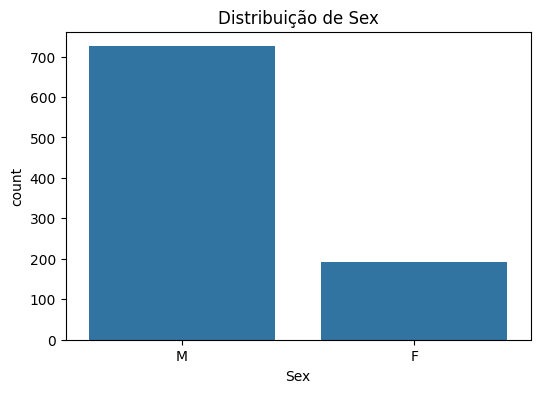

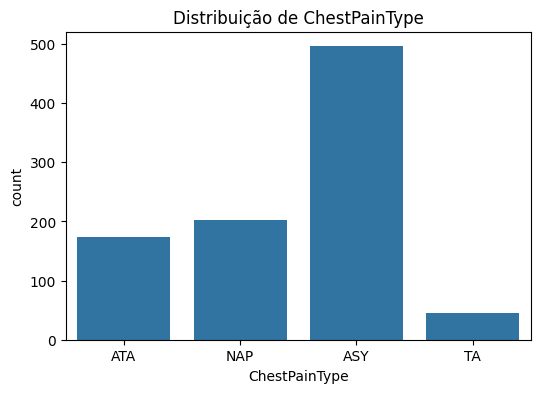

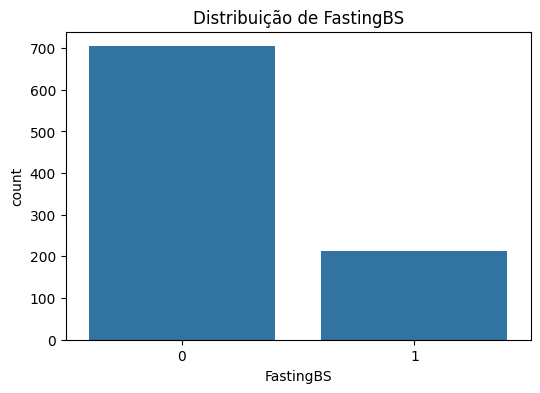

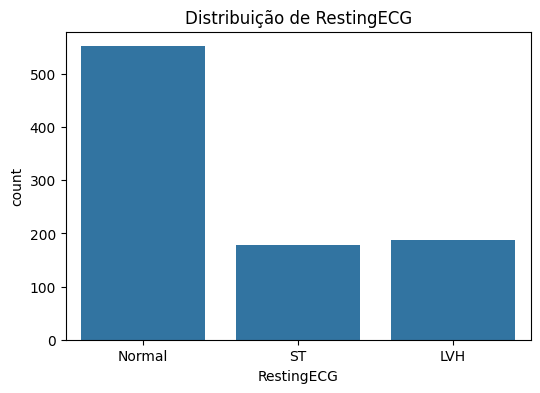

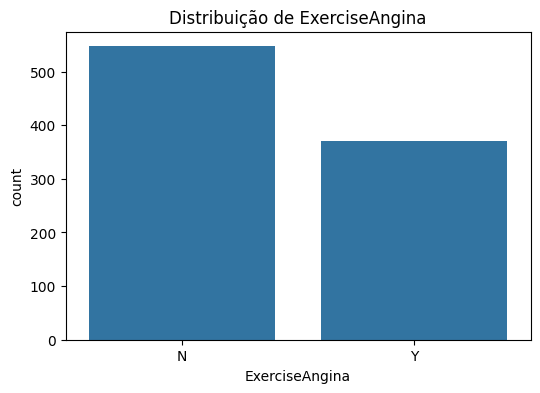

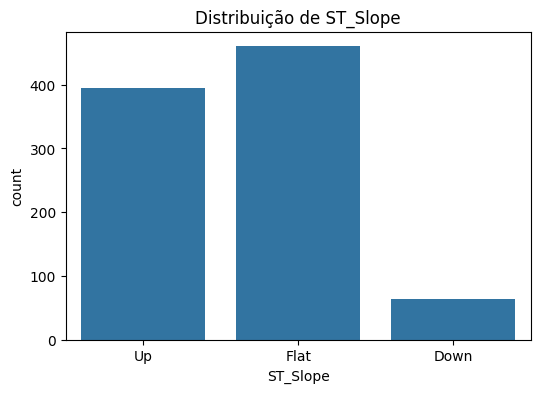

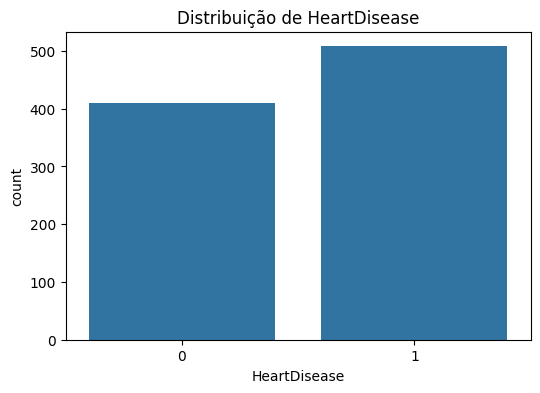

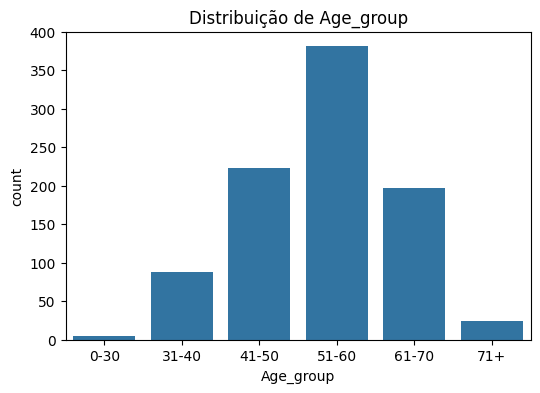

In [ ]:
# observando a distribuição das variáveis categóricas
for i in colunas_cat:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=i, data=df)
    plt.title(f'Distribuição de {i}')
    plt.show()

<Axes: xlabel='HeartDisease', ylabel='count'>

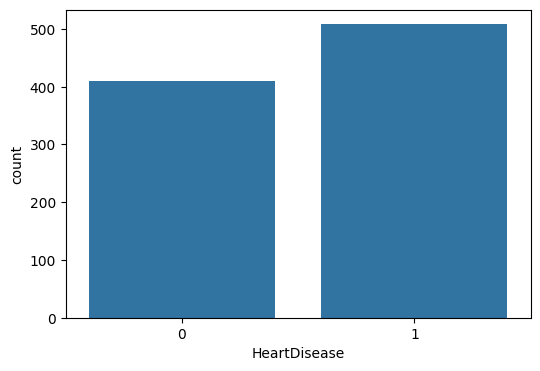

In [ ]:
# distribuição da variável target
plt.figure(figsize=(6, 4))
sns.countplot(x='HeartDisease', data=df)

Algumas informações sobre as variáveis categóricas:

- Existem mais homens do que mulheres na base de dados.

- A variável target é relativamente balanceada (55%–45%), então não é necessário utilizar SMOTE, já que isso poderia gerar ruídos desnecessários.

- A maioria dos pacientes é assintomática quando se trata de dores na região do tórax.

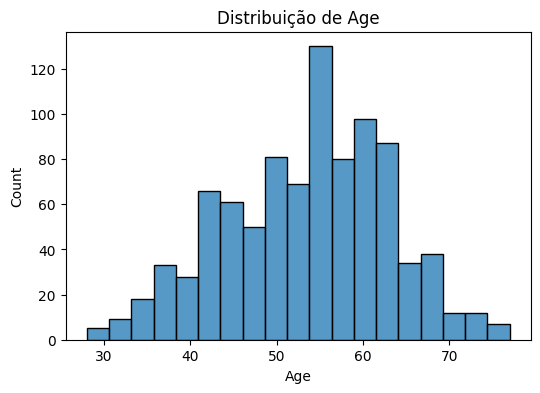

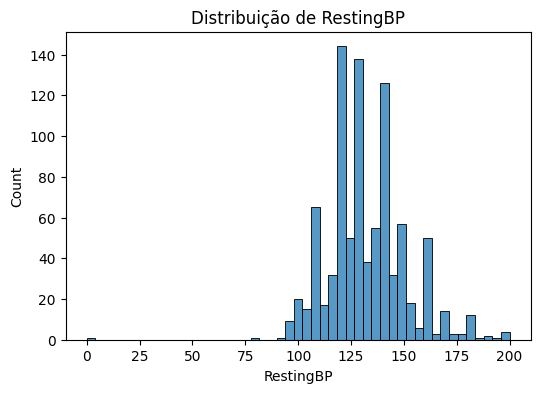

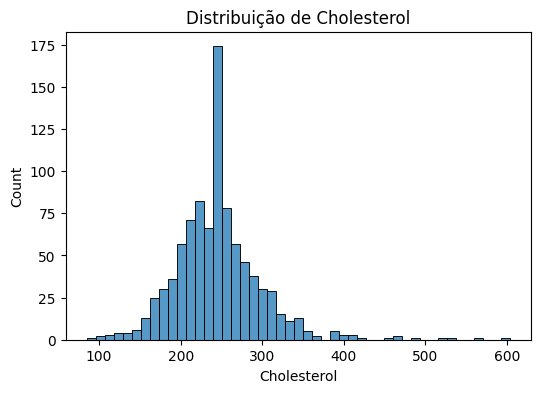

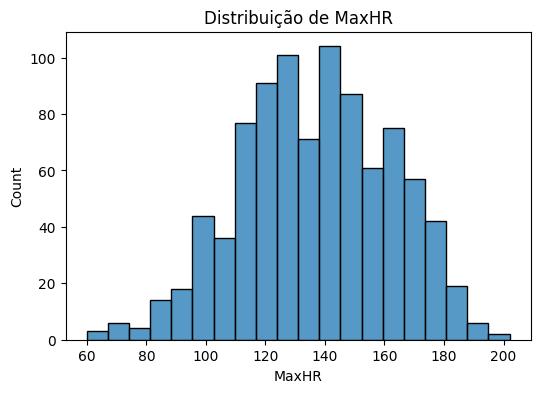

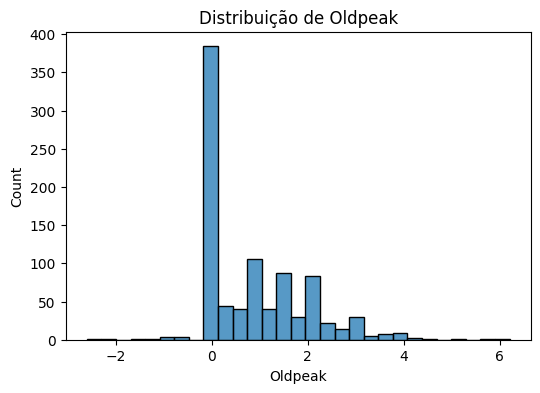

In [ ]:
# observando a distribuição das variáveis númericas
for i in colunas_num:
    plt.figure(figsize=(6, 4))
    sns.histplot(x=i, data=df)
    plt.title(f'Distribuição de {i}')
    plt.show()

Algumas informações sobre as variáveis numéricas:

- O colesterol apresenta alguns outliers, mas, para essa base, acredito que seja melhor mantê-los, já que os dados não parecem ter sido imputados de forma incorreta e podem representar casos extremos reais de pacientes.

- Os pacientes têm idades que variam de 28 a 77 anos, ou seja, a predição será focada em indivíduos adultos.

### Variáveis categóricas e númericas x variável target

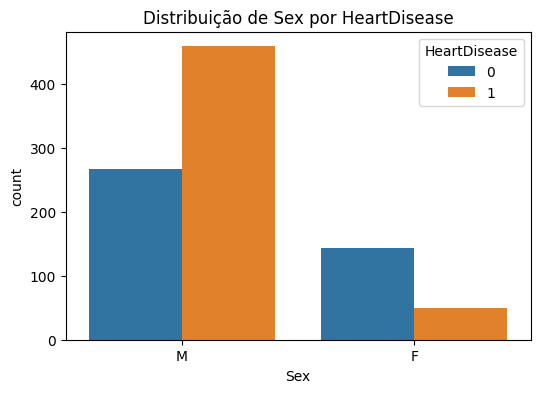

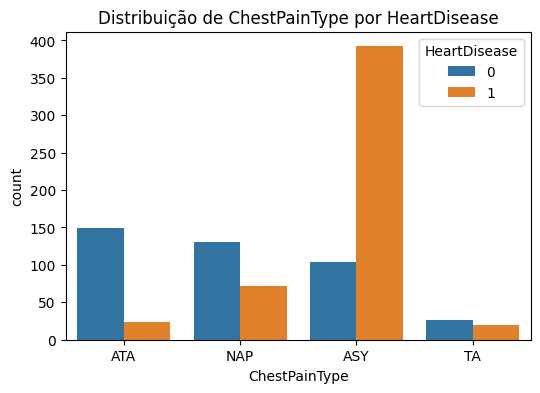

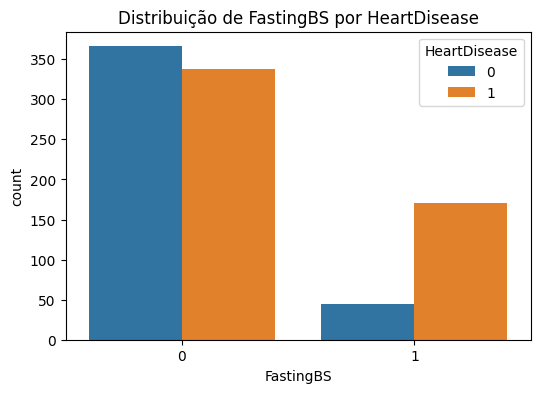

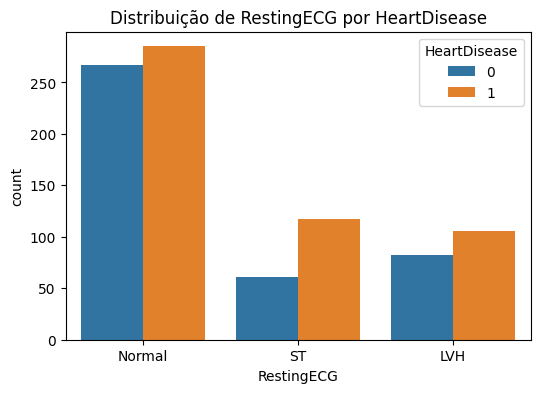

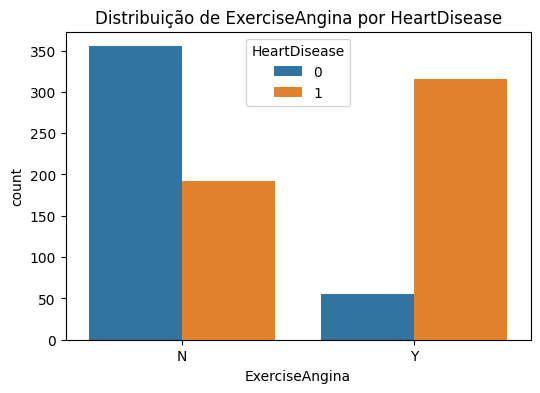

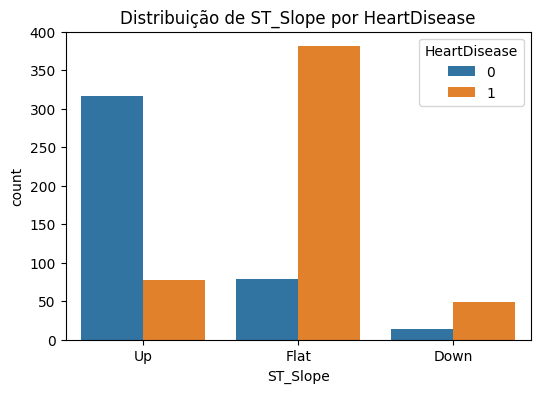

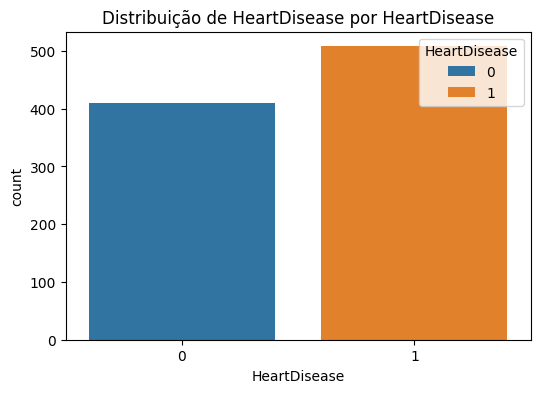

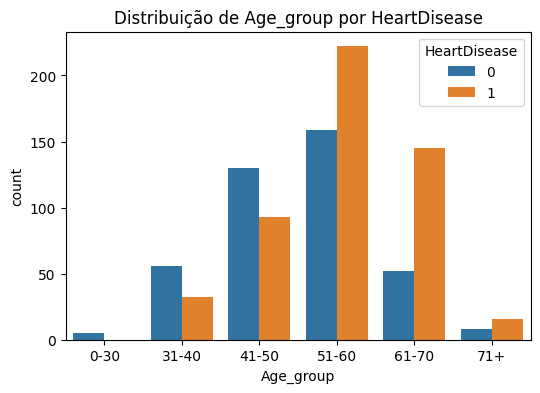

In [ ]:
for i in colunas_cat:
    plt.figure(figsize=(6,4))
    sns.countplot(x=i, hue='HeartDisease', data=df)
    plt.title(f'Distribuição de {i} por HeartDisease')
    plt.show()


Informações obtidas ao observar a interação das variáveis categóricas com a variável target:

- Homens apresentam mais casos de doenças cardíacas do que mulheres na base. (Importante considerar que há mais pacientes homens, o que pode introduzir viés.)

- Pacientes assintomáticos (sem dores) tendem a apresentar mais casos de doenças cardíacas, provavelmente por não procurarem atendimento médico com frequência, já que não sentem sintomas.

- Pacientes que apresentam angina ao praticar exercícios têm probabilidade consideravelmente maior de testar positivo para doença cardíaca.

- O ST_Slope na categoria “Flat” indica que o paciente provavelmente possui alguma anormalidade cardíaca.

- Pessoas mais velhas, especialmente a partir dos 50 anos, apresentam maior tendência a desenvolver doenças cardíacas.

In [ ]:
# separando as variáveis numéricas em grupos para a visualização
# RestingBP
bins_restingBP = [0, 75, 100, 125, 150, 175, df['RestingBP'].max() + 1]
labels_restingBP = ['0-75', '76-100', '101-125', '126-150', '151-175', '176+']
df['RestingBP_binned'] = pd.cut(df['RestingBP'], bins=bins_restingBP, labels=labels_restingBP, right=False)

# Cholesterol
bins_cholesterol = [0, 100, 200, 300, 400, 500, df['Cholesterol'].max() + 1]
labels_cholesterol = ['0-100', '101-200', '201-300', '301-400', '401-500', '501+']
df['Cholesterol_binned'] = pd.cut(df['Cholesterol'], bins=bins_cholesterol, labels=labels_cholesterol, right=False)

# MaxHR
bins_maxHR = [0, 60, 80, 100, 120, 140, 160, 180, df['MaxHR'].max() + 1]
labels_maxHR = ['0-60', '61-80', '81-100', '101-120', '121-140', '141-160', '161-180', '181+']
df['MaxHR_binned'] = pd.cut(df['MaxHR'], bins=bins_maxHR, labels=labels_maxHR, right=False)

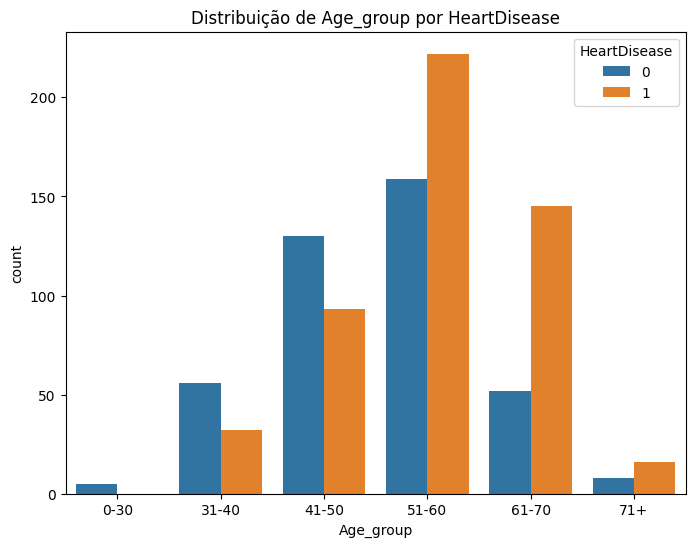

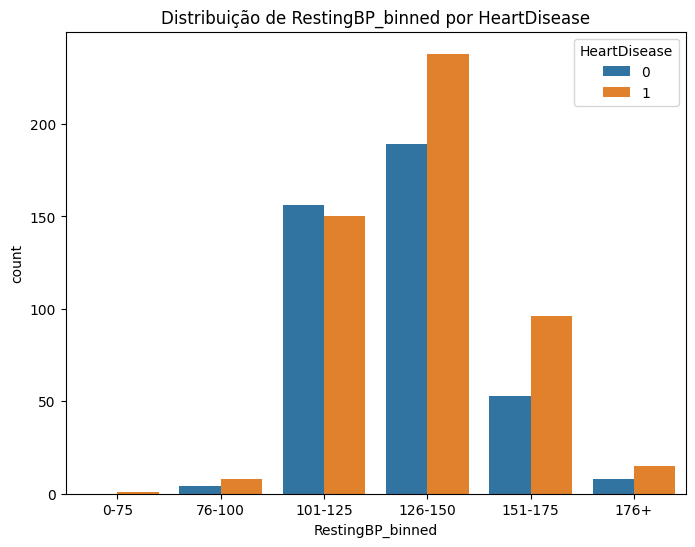

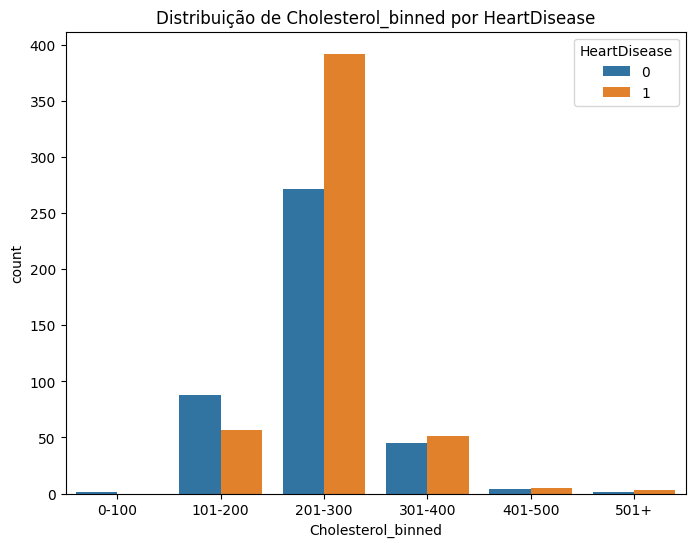

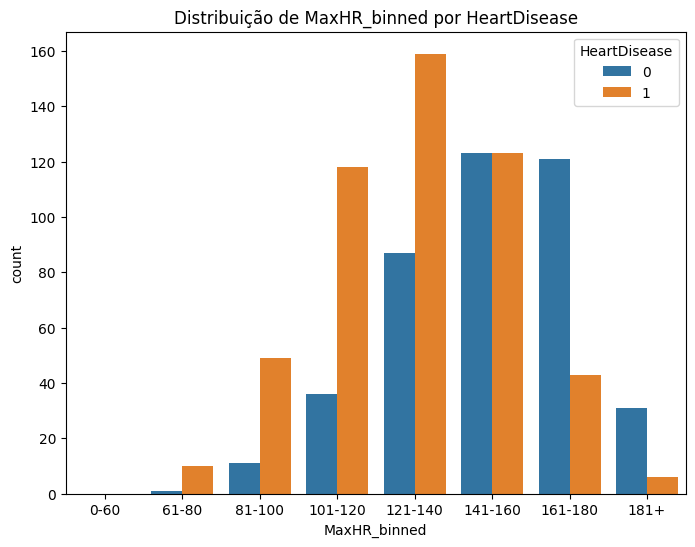

In [ ]:
# plotando as variáveis numéricas por grupos em relação a variável target
for i in ['Age_group', 'RestingBP_binned', 'Cholesterol_binned', 'MaxHR_binned']:
    plt.figure(figsize=(8,6))
    sns.countplot(x=i, hue='HeartDisease', data=df)
    plt.title(f'Distribuição de {i} por HeartDisease')
    plt.show()

Informações obtidas ao analisar as variáveis numéricas agrupadas pela target:

- Pacientes com pressão arterial, colesterol e batimentos cardíacos elevados apresentam maior probabilidade de desenvolver doenças cardíacas.

### Comparando variáveis que parecem ter alta correlação com HeartDisease

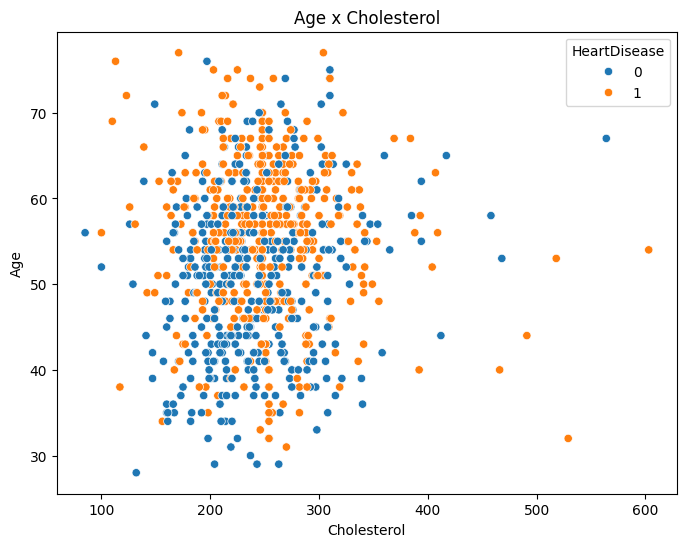

In [ ]:
# cholesterol x age
plt.figure(figsize=(8,6))
sns.scatterplot(x='Cholesterol', y='Age', hue='HeartDisease', data=df)
plt.title('Age x Cholesterol')
plt.show()

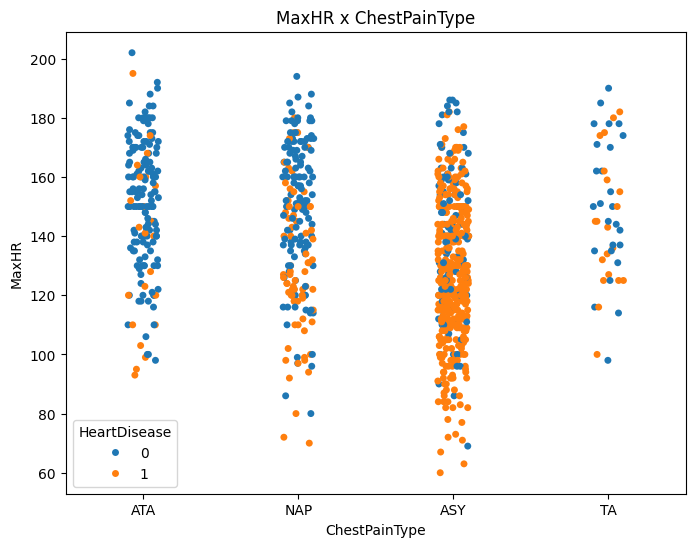

In [ ]:
# chestpain type x maxHR
plt.figure(figsize=(8,6))
sns.stripplot(x='ChestPainType', y='MaxHR', hue='HeartDisease', data=df)
plt.title('MaxHR x ChestPainType')
plt.show()

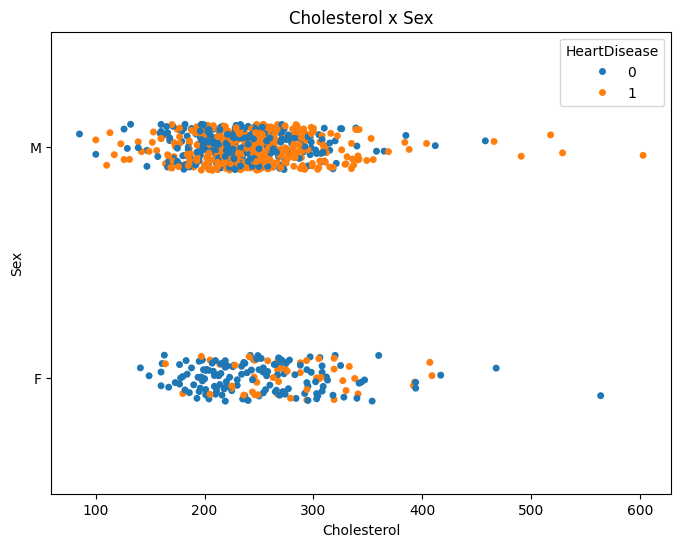

In [ ]:
# cholesterol x gender
plt.figure(figsize=(8,6))
sns.stripplot(x='Cholesterol', y='Sex', hue='HeartDisease', data=df)
plt.title('Cholesterol x Sex')
plt.show()

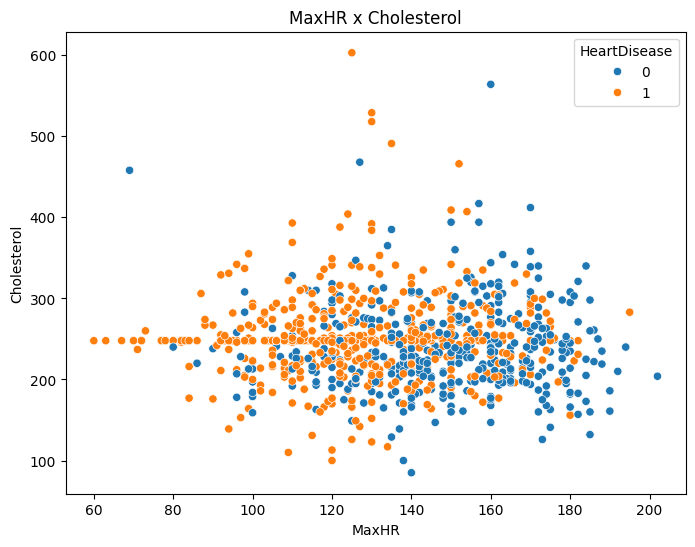

In [ ]:
# maxHR x cholesterol
plt.figure(figsize=(8,6))
sns.scatterplot(x='MaxHR', y='Cholesterol', hue='HeartDisease', data=df)
plt.title('MaxHR x Cholesterol')
plt.show()

Observando as variáveis comparadas entre si, é possível perceber que:

- Pessoas mais velhas tendem a apresentar níveis mais altos de colesterol.

- Não há grandes indícios de diferença nos tipos de dores quando comparados ao valor máximo de batimentos cardíacos.

- Homens e mulheres apresentam níveis de colesterol bastante parecidos.

- Pessoas com batimentos cardíacos mais baixos e colesterol elevado aparentam ter mais casos positivos de doença cardíaca.

# Seleção de features

In [ ]:
colunas_visualizacao = ['Age_group', 'RestingBP_binned', 'Cholesterol_binned',
       'MaxHR_binned']
df_clean = df.drop(columns=colunas_visualizacao)

In [ ]:
ordinal_mapping_dicts = {
    'Sex': {'M': 0, 'F': 1},
    'ChestPainType': {'TA':4, 'ATA':3, 'NAP':2, 'ASY':1},
    'RestingECG': {'Normal':0, 'ST':1, 'LVH':2},
    'ExerciseAngina': {'N':0, 'Y':1},
    'ST_Slope': {'Up':1, 'Flat':2, 'Down':3}
}

for col, map_dict in ordinal_mapping_dicts.items():
    df_clean[col] = df_clean[col].map(map_dict)

<Axes: >

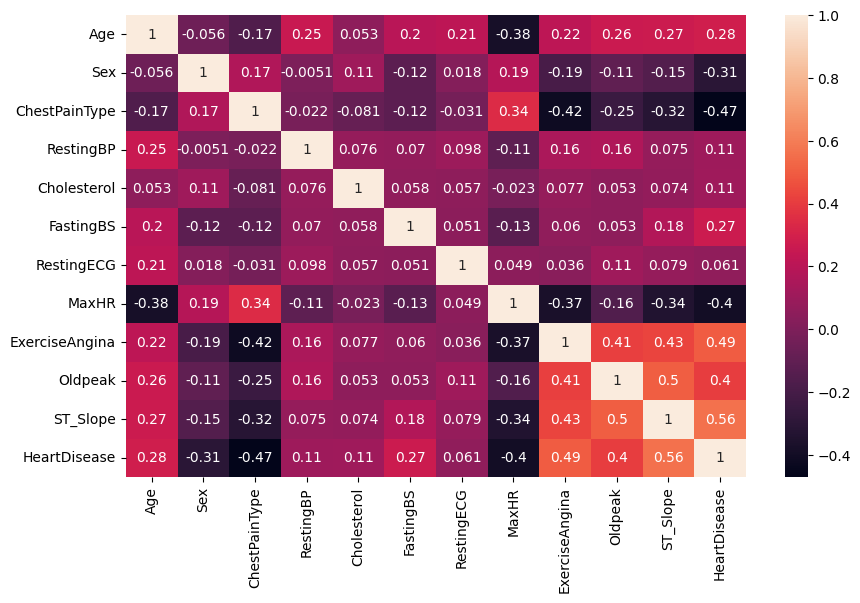

In [ ]:
# plotando a matriz de correlação
corr = df_clean.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True)

Text(0.5, 1.0, 'Selection of Categorical Features')

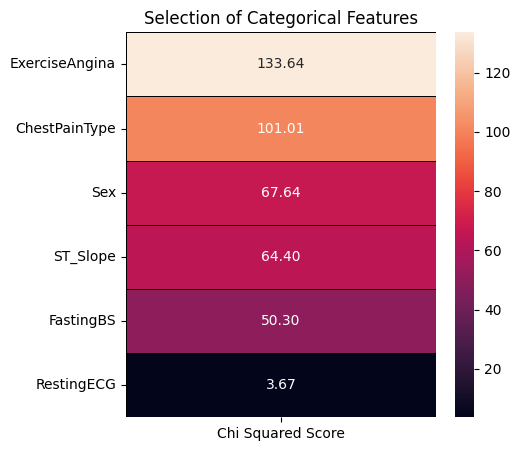

In [ ]:
# Seleção de featurtes categóricas
colunas_cat.remove('Age_group')

features = df_clean.loc[:,colunas_cat[:-1]]
target = df_clean.loc[:,colunas_cat[-1]]


best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score'])

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features')

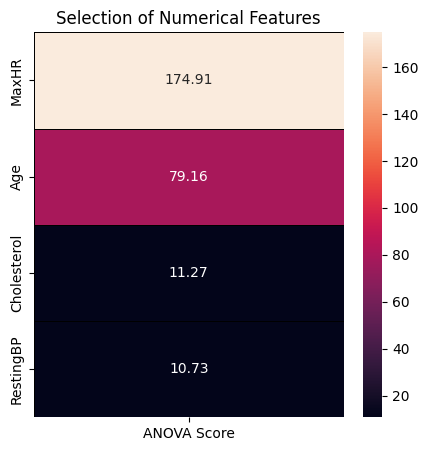

In [ ]:
from sklearn.feature_selection import f_classif

# Seleção de features numéricas
features = df_clean.loc[:,colunas_num[:-1]]
target = df_clean.loc[:,colunas_cat[-1]]

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score'])

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

"RestingBP" e "RestingEGC" serão removidas no treino por não aparentarem ter grande importância para o treinamento.

# Treinamento do modelo

In [ ]:
df.HeartDisease.value_counts()

,count
HeartDisease,
1,508
0,410


In [ ]:
# separando as features
df_modelagem = df.drop(columns=colunas_visualizacao)

X = df_modelagem.drop(['HeartDisease','RestingBP','RestingECG'], axis = 1)
y = df_modelagem['HeartDisease']

# separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# criando o dicionário para mapeamento das colunas
ordinal_mapping_dicts = {
    'Sex': {'M': 0, 'F': 1},
    'ChestPainType': {'TA':4, 'ATA':3, 'NAP':2, 'ASY':1},
    'ExerciseAngina': {'N':0, 'Y':1},
    'ST_Slope': {'Up':1, 'Flat':2, 'Down':3}
}

# coluna Binárias (que não precisam de transformação, pois já são 0 ou 1)
binary_cols = ['FastingBS']

# lista das colunas que serão transformadas pelo OrdinalMapper
ordinal_cols = list(ordinal_mapping_dicts.keys())

# colunas que receberão scaling
standard_cols = ['Age', 'Cholesterol', 'MaxHR']
minmax_cols = ['Oldpeak']

In [ ]:
# criando uma classe para mapear as colunas categóricas levando em consideração o peso de cada valor
class OrdinalMapper(BaseEstimator, TransformerMixin):
    def __init__(self, mapping):
        self.mapping = mapping

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_out = X.copy()
        for col, map_dict in self.mapping.items():
            # aplica o mapeamento
            X_out[col] = X_out[col].map(map_dict)

            # trata valores que não foram mapeados (novas categorias)
            # preenche com -1. Isso garante que o modelo veja um valor numérico.
            X_out[col] = X_out[col].fillna(-1)

        # Converte para o tipo numérico (int) após o preenchimento
        X_out = X_out.astype(int)
        return X_out

preprocessor = ColumnTransformer(
    transformers=[
        # codificação Ordinal Manual
        ('ordinal', OrdinalMapper(ordinal_mapping_dicts), ordinal_cols),
        # padronização (StandardScaler)
        ('standard', StandardScaler(), standard_cols),
        # normalização (MinMaxScaler)
        ('minmax', MinMaxScaler(), minmax_cols),
    ],
    # deixa as colunas binárias (e outras que sobraram) passarem sem modificação
    remainder='passthrough',
    verbose_feature_names_out=False # define que o output terá nomes de colunas simples
)

In [ ]:
# treinamento do modelo
# modelos base
estimators = [
    ('xgb', XGBClassifier(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42,)),
    ('catboost', CatBoostClassifier(random_state=42,)),
]

# modelo meta (final)
meta_model = LogisticRegression(max_iter=1000)

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

# pipeline final de processamento e treinamento
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', stack_model)
])

In [ ]:
param_distributions = {
    # XGBoost ('xgb')
    'model__xgb__n_estimators': randint(low=200, high=600), # Amostra inteiros entre 200 e 600
    'model__xgb__max_depth': randint(low=4, high=8),
    'model__xgb__learning_rate': uniform(loc=0.01, scale=0.1), # Uniforme entre 0.01 e 0.11 (0.01 + 0.1)

    # RandomForest ('rf')
    'model__rf__n_estimators': randint(low=100, high=400),
    'model__rf__max_depth': randint(low=6, high=12),

    # CatBoost ('catboost')
    'model__catboost__n_estimators': randint(low=300, high=500),
    'model__catboost__learning_rate': loguniform(0.01, 0.15),
    'model__catboost__depth': randint(low=4, high=7),

    # Logistic Regression ('meta modelo')
    'model__final_estimator__C': loguniform(1e-4, 1e2),
    'model__final_estimator__solver': ['liblinear', 'lbfgs'],
    'model__final_estimator__penalty': ['l2'],
}

In [ ]:
# Configuração do RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=final_pipeline,
    param_distributions=param_distributions,
    n_iter=100,             # número de combinações (amostras) a serem testadas.
    scoring='roc_auc',      # Métrica de avaliação (roc_auc)
    cv=3,                  # CV externa
    verbose=0,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Avaliação final no conjunto de teste
best_stacking_model = random_search.best_estimator_
y_pred = best_stacking_model.predict(X_test)

### Resumo do Fluxo de Trabalho de Modelagem
- Pré-Processamento Estruturado: As transformações de dados (Codificação Ordinal Manual via OrdinalMapper e Escalonamento com StandardScaler/MinMaxScaler) foram encapsuladas no ColumnTransformer.

- Pipeline: O Pipeline recebe o ColumnTransformer (garantindo que todas as transformações ocorram corretamente dentro da Cross-Validation, eliminando Data Leakage) e, em seguida, o StackingClassifier.

- Stacking (Empilhamento): O StackingClassifier combina as previsões de três Modelos Base (XGBoost, CatBoost, Random Forest) e as passa para o Meta-Modelo (Regressão Logística), criando um preditor mais robusto.

- Otimização: O Pipeline completo (contendo o pré-processamento e o Stacking) foi submetido ao RandomizedSearchCV e à Cross-Validation para encontrar os melhores Hiperparâmetros para todos os modelos de forma eficiente.

# Avaliando o modelo

In [ ]:
# observando os resultados do modelo stackado
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        77
           1       0.91      0.88      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



<Axes: >

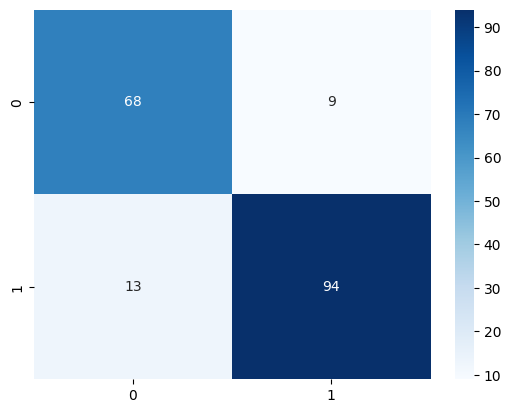

In [ ]:
# plotando a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

Melhor score ROC_AUC: 0.9309


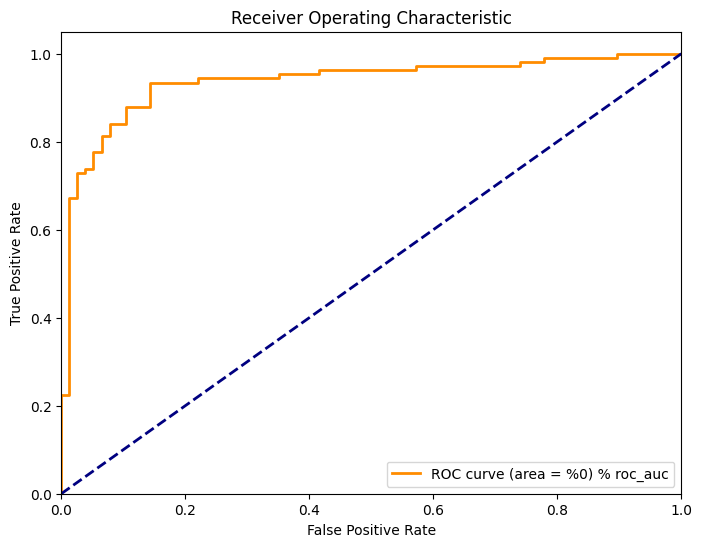

In [ ]:
# plotando a curva ROC
from sklearn.metrics import roc_curve, auc
print(f"Melhor score ROC_AUC: {random_search.best_score_:.4f}")

y_pred_proba = best_stacking_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0) % roc_auc')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# utilizando cross validation
scores = cross_val_score(best_stacking_model, X_train, y_train, cv=5, scoring='roc_auc')
scores.mean()

np.float64(0.9306502490354067)

O modelo apresentou resultados satisfatórios. Suas métricas foram:

- F1-score de 0,86 para a classe 0 e 0,90 para a classe 1;

- Média de 0,93 no ROC AUC;

- Acurácia de 0,88.

As previsões geradas tendem a ser corretas e consistentes, indicando que o modelo está pronto para ser utilizado em cenários reais.

#Retreinando o modelo com toda a base antes de colocá-lo em produção e salvando

###Retreinar o modelo com 100% dos dados antes de colocá-lo em produção é a melhor prática porque:

- Máximo aprendizado: o modelo final é treinado com a quantidade máxima de informação disponível (Treino + Teste). Isso permite que ele aprenda mais padrões e exceções, resultando em um modelo mais robusto e mais preciso para o ambiente de produção.

- Confiança validada: você já validou a melhor arquitetura e os melhores hiperparâmetros (best_estimator_) no conjunto de teste. O retreino apenas aplica essa configuração vencedora ao conjunto completo.

- Modelo final otimizado: o modelo que será salvo e utilizado para previsões reais deve ser aquele que teve a oportunidade total de aprender com todos os dados históricos disponíveis.

- Importante destacar: as métricas apresentadas são do modelo treinado no conjunto de treino e validado no conjunto de teste, garantindo imparcialidade e ausência de overfitting.

In [ ]:
# retreinando o modelo com todo o dataframe antes de colocá-lo em produção
best_stacking_model.fit(X, y)

# carregando o modelo como arquivo
import joblib
import os

# Defina o nome do arquivo
NOME_ARQUIVO = 'modelo_stacking_final_todos_os_dados.joblib'

# 1. Salvar o modelo/pipeline completo
try:
    joblib.dump(best_stacking_model, NOME_ARQUIVO)
    print(f"Modelo salvo com sucesso em: {NOME_ARQUIVO}")
except Exception as e:
    print(f"Erro ao salvar o modelo: {e}")

Modelo salvo com sucesso em: modelo_stacking_final_todos_os_dados.joblib
